In [1]:
import os
import random
import time
import glob
import json
import dit
import itertools
import time
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns;sns.set()
import pandas as pd
from scipy.optimize import minimize
os.chdir("../")
from helpers.group_helpers import classify_syms, srv_to_mat, getcond, oversizedsyms
from helpers.compare_helpers import appendtoPXS,load_frame,addbestsym
from helpers.helpers import SeabornFig2Grid
from jointpdfpython3.measures import synergistic_entropy_upper_bound, append_random_srv
from jointpdfpython3.params_matrix import params2matrix_incremental,matrix2params_incremental
from jointpdfpython3.JointProbabilityMatrix import JointProbabilityMatrix
from syndisc.syndisc import self_disclosure_channel
os.chdir("./plot_notebooks")

dict_keys(['full sym', 'oversized states 3', 'oversized states 4', 'oversized states 5', 'oversized states 6', 'noisy sym'])


C:\Users\enrik\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.


([], [])

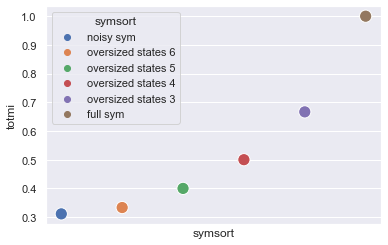

In [85]:
states=2
if states == 5:
    print("LOAD LOWER ORDER AND FULL ONLY")
    with open('../../results/sudokus/permutation_sudokus_states'+str(states)+'.npy', 'rb') as f:
        fullsyms = np.load(f,allow_pickle=True)
        syms = list(fullsyms)
    with open('../../results/sudokus/lowerorder_sudokus_states'+str(states)+'.pkl', 'rb') as f:
        lowerorders=pickle.load(f)
        syms = syms+list(lowerorders)
    syms=np.array(syms)
else:
    with open('../../results/sudokus/constructedSRVstates'+str(states)+'.npy', 'rb') as f:
        syms = np.load(f,allow_pickle=True)
        
l,cs=classify_syms(syms,states)
if states ==2:
    cs['noisy sym']=cs.pop('lower order sym')
print(cs.keys())
juni = JointProbabilityMatrix(2,states,joint_probs='iid')
pX = juni.joint_probabilities.joint_probabilities

data = {'totmi':[],'indivmi':[],'symsort':[]}
for c in cs:
    cur = cs[c][0]
    pXS = appendtoPXS(2,pX,pX,syms[cur])
    dXS = dit.Distribution.from_ndarray(pXS)
    indivmi = sum([dit.shannon.mutual_information(dXS,[i],[2]) for i in range(2)])
    totmi = dit.shannon.mutual_information(dXS,[0,1],[2])
    data['totmi'].append(totmi)
    data['indivmi'].append(indivmi)
    data['symsort'].append(c)
df = pd.DataFrame(data=data)
df=df.sort_values(by=['totmi'])
sns.scatterplot(data=df,x='symsort',y='totmi',hue='symsort',s=150)
plt.xticks([])

([<matplotlib.axis.XTick at 0x1cc30314b00>,
 [Text(0, 0, 'states 2'),
  Text(1, 0, 'states 3'),
  Text(2, 0, 'states 4'),
  Text(3, 0, 'states 5')])

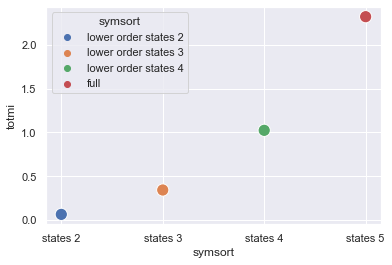

In [83]:
def classifylowerorders(syms):
    classes = {}
    states = len(syms[0][0])
    for i,s in enumerate(syms):
        order = 0
        for row in s:
            cur = states-len(np.where(row==1/states)[0])
            if cur!=0 and order == 0:
                order = int(cur)
            else:
                continue
        k = 'lower order states '+str(order)
        if k not in classes.keys():
            classes[k] = []
        classes['lower order states '+str(order)].append(i)
    return classes

lowercs = classifylowerorders(lowerorders)
cs ={'full':syms[0]}
for k,a in lowercs.items():
    cs[k] = lowerorders[a[0]]
    
juni = JointProbabilityMatrix(2,states,joint_probs='iid')
pX = juni.joint_probabilities.joint_probabilities

data = {'totmi':[],'indivmi':[],'symsort':[]}
for c in cs:
    cur = cs[c]
    pXS = appendtoPXS(2,pX,pX,cur)
    dXS = dit.Distribution.from_ndarray(pXS)
    indivmi = sum([dit.shannon.mutual_information(dXS,[i],[2]) for i in range(2)])
    totmi = dit.shannon.mutual_information(dXS,[0,1],[2])
    data['totmi'].append(totmi)
    data['indivmi'].append(indivmi)
    data['symsort'].append(c)
df = pd.DataFrame(data=data)
df=df.sort_values(by=['totmi'])
sns.scatterplot(data=df,x='symsort',y='totmi',hue='symsort',s=150)
plt.xticks(np.arange(len(df['totmi'])),['states '+str(i+2) for i in range(len(df['totmi']))])

## syn info for different sym classes

C:\Users\enrik\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\enrik\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<class 'helpers.helpers.SeabornFig2Grid'> <class 'seaborn.axisgrid.JointGrid'> <class 'matplotlib.gridspec.SubplotSpec'>


C:\Users\enrik\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<class 'helpers.helpers.SeabornFig2Grid'> <class 'seaborn.axisgrid.JointGrid'> <class 'matplotlib.gridspec.SubplotSpec'>


C:\Users\enrik\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<class 'helpers.helpers.SeabornFig2Grid'> <class 'seaborn.axisgrid.JointGrid'> <class 'matplotlib.gridspec.SubplotSpec'>


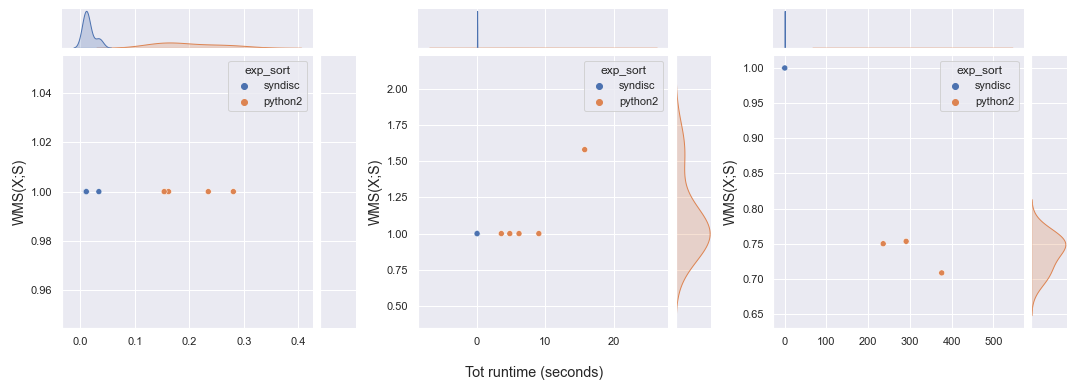

In [18]:
fig = plt.gcf()
fig.set_size_inches(15,7.5)
xlabel = 'tot_runtime'
ylabels = ['WMS(X;S)']
gs = gridspec.GridSpec(len(ylabels),len(states))
gs.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

for i, idxs in enumerate(itertools.product(ylabels, states)):
    nrt, nvar = idxs
    g = sns.jointplot(data=d[d['states']==nvar], x=xlabel, y=nrt,hue='exp_sort'
                     ,marginal_ticks=False) 

    g.set_axis_labels(None,nrt,fontsize=14)
    m = SeabornFig2Grid(g, fig, gs[i])  
#     axeset_title('My Title', fontdict={'fontsize': 8, 'fontweight': 'medium'})
    print(type(m),type(g),type(gs[i]))
    # annotate subfig
#     g.ax_joint.annotate(f'$ states = {nvar:.0f}$',
#       xy=(0.05, 0.95), xycoords='axes fraction',
#       ha='right', va='center',
#       bbox={'boxstyle': 'round', 'fc': 'lightgrey', 'ec': 'black'})

fig.supxlabel("Tot runtime (seconds)")
gs.tight_layout(fig)
gs.update(top=0.7)
plt.show()
# fig.savefig('../../results/comparison/'+dist_type+'.png')
# os.chdir('../../code/plot_notebooks')
